File loaded successfully!
[INFO] Applying 60Hz notch filter to remove power line interference...
[SUCCESS] 60Hz notch filter applied.
Applied a 1-70 Hz band-pass filter.
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T3, T5, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T4, T6, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 70.0 Hz
 meas_date: 2025-05-10 18:55:25 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, first_name: X, last_name: X>
>
[INFO] Renamed channels for montage: {'T3': 'T7', 'T4': 'T8', 'T5': 'P7', 'T6': 'P8'}
[INFO] Channel types set: {'eeg': 22, 'eog': 2, 'ecg': 2, 'emg': 2, 'misc': 18}
[INFO] Montage set: standard_1020
[INFO] Preparing data for ICA (EEG only, 1–40 Hz) ...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin

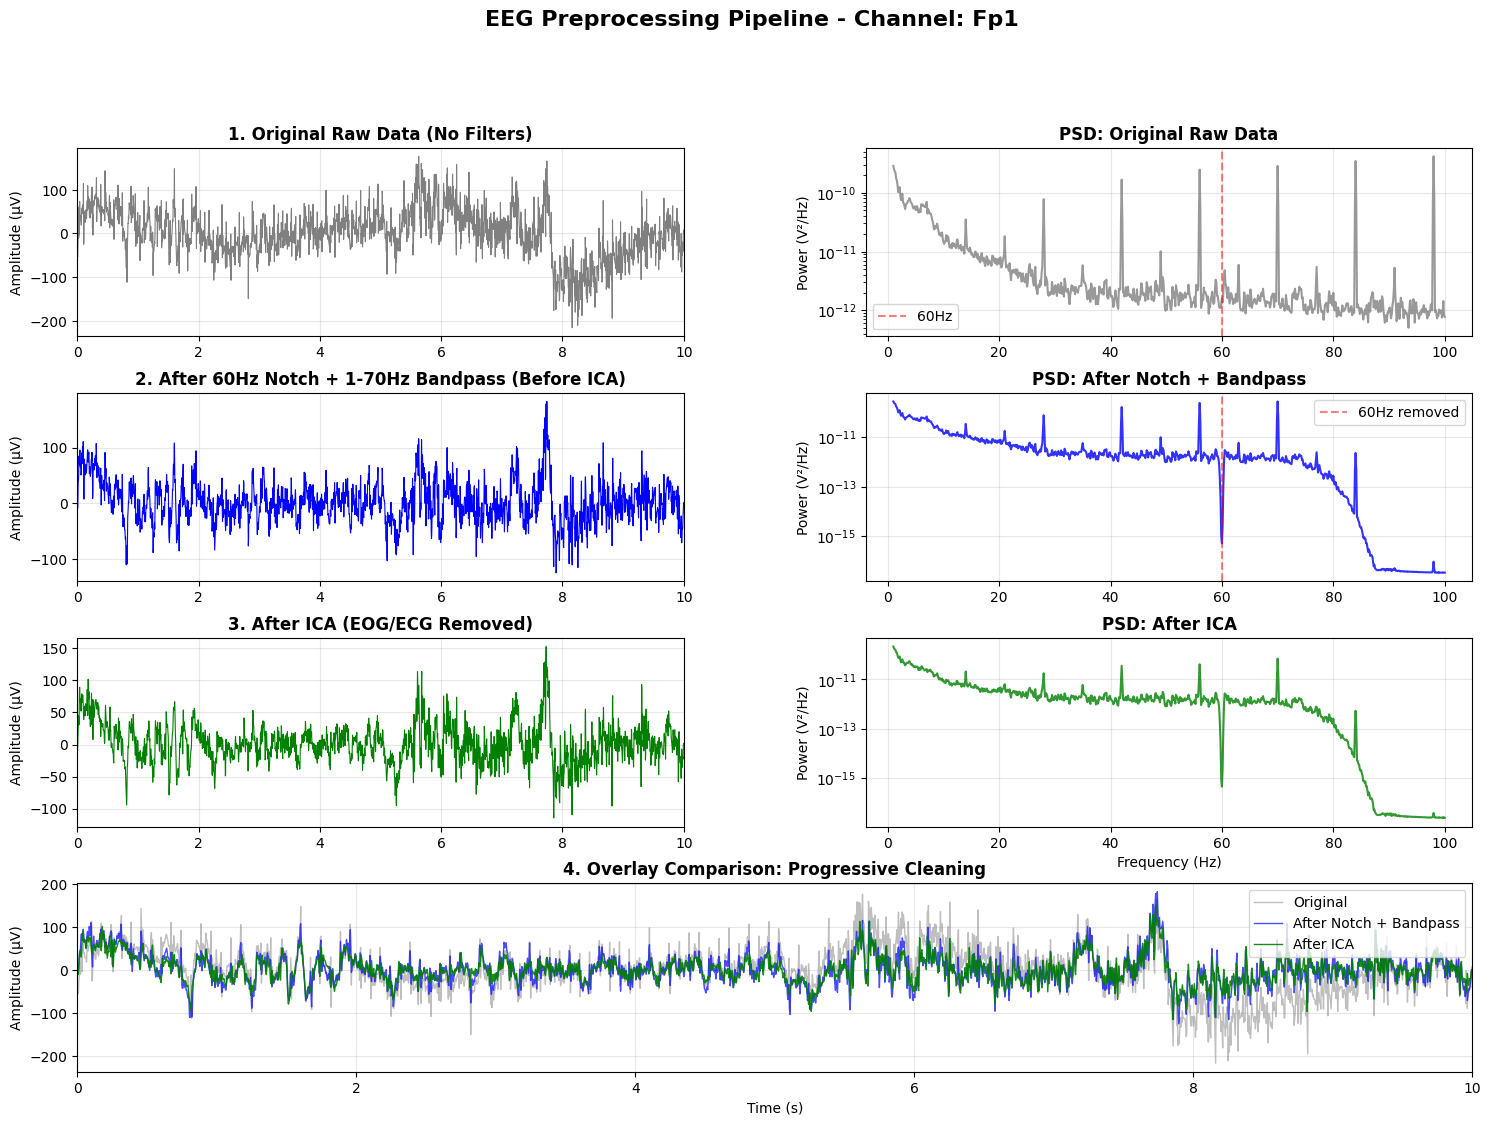

[SUCCESS] Filtering comparison visualization complete.


In [22]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import warnings

# Set Matplotlib to display plots inline in Jupyter Notebooks
%matplotlib inline

# File path
file_path = 'XUAWAKE7.EDF'

# Load the EDF file using MNE-Python
# preload=True loads the data into memory for easier processing
try:
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw_unfiltered = raw.copy()
    print("File loaded successfully!")
    
    # ========== IMPROVEMENT: Add 60Hz Notch Filter ==========
    # NECESSITY: Power line interference at 60Hz (USA) or 50Hz (Europe/Asia) is a
    # major source of noise in EEG recordings. Notch filtering removes this artifact
    # while preserving the neural signals of interest.
    # IFCN Best Practices recommend notch filtering before band-pass filtering.
    print("[INFO] Applying 60Hz notch filter to remove power line interference...")
    raw.notch_filter(freqs=60, picks='eeg', method='fir', fir_design='firwin', 
                     phase='zero', verbose=False)
    print("[SUCCESS] 60Hz notch filter applied.")
    
    # Apply a band-pass filter as recommended by the paper to remove DC offset and high-frequency noise
    raw.filter(l_freq=1.0, h_freq=70.0)
    print("Applied a 1-70 Hz band-pass filter.")
    # Print data information
    print(raw.info)
except Exception as e:
    print(f"Failed to load file: {e}")

# Rename legacy names: T3/T4/T5/T6 -> T7/T8/P7/P8 before montage
rename_map = {}
if "T3" in raw.ch_names: rename_map["T3"] = "T7"
if "T4" in raw.ch_names: rename_map["T4"] = "T8"
if "T5" in raw.ch_names: rename_map["T5"] = "P7"
if "T6" in raw.ch_names: rename_map["T6"] = "P8"
if len(rename_map):
    mne.rename_channels(raw.info, mapping=rename_map)
    print(f"[INFO] Renamed channels for montage: {rename_map}")

# Set channel types based on your list (EEG/EOG/ECG/EMG/MISC)
# LOC1/LOC2→EOG；EKGL/EKGR/ECG→ECG；EMG1/2→EMG；A1/A2/DC*/X*/OSAT/PR→misc；else→EEG
types_map = {}
for ch in raw.ch_names:
    u = ch.upper()
    if u in {"EKGL", "EKGR", "ECG"} or u.startswith("EKG"):
        types_map[ch] = "ecg"
    elif u in {"LOC1", "LOC2", "EOG", "VEOG", "HEOG"} or u.startswith("EOG"):
        types_map[ch] = "eog"
    elif u.startswith("EMG") or u in {"EMG1", "EMG2"}:
        types_map[ch] = "emg"
    elif u.startswith("DC") or u.startswith("X") or u in {"OSAT", "PR","A1","A2"}:
        types_map[ch] = "misc"
    else:
        types_map[ch] = "eeg"

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="The unit .* has changed from .* to NA")
    raw.set_channel_types(types_map)
print("[INFO] Channel types set:",
      {k: sum(v == k for v in types_map.values()) for k in ["eeg", "eog", "ecg", "emg", "misc"]})

# ========== 2) montage ==========
try:
    raw.set_montage("standard_1020", match_case=False, on_missing="ignore")
    print("[INFO] Montage set: standard_1020")
except Exception as e:
    print(f"[WARN] Montage issue: {e}")

# ========== 3) ICA ==========
picks_eeg = mne.pick_types(raw.info, eeg=True, eog=False, ecg=False, emg=False, misc=False)
if len(picks_eeg) == 0:
    raise RuntimeError("No EEG channels picked for ICA.")

print("[INFO] Preparing data for ICA (EEG only, 1–40 Hz) ...")
raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=40.0, picks=picks_eeg,
                                phase="zero", fir_design="firwin", verbose=True)

# Save raw before ICA for comparison plotting
raw_before_ica = raw.copy()

# ========== 4) FITTING ICA ==========
try:
    import picard  # noqa: F401
    ica_method = "picard"
except Exception:
    ica_method = "fastica"

n_eeg = len(picks_eeg)
fit_params = None
if ica_method == "fastica":
    # For MNE 1.9.0, pass sklearn FastICA kwargs via fit_params
    fit_params = dict(tol=5e-4)

print(f"[INFO] Fitting ICA with method={ica_method} ...")
ica = mne.preprocessing.ICA(
    n_components=min(n_eeg, 40),  # 32–40）
    method=ica_method,
    random_state=97,
    max_iter=1000,               
    fit_params=fit_params,
    verbose=True
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    ica.fit(raw_for_ica, picks=picks_eeg, decim=2, reject_by_annotation=True)

print(f"[INFO] ICA fitted. n_components_={ica.n_components_}")

# ========== 5) EOG/ECG ==========
def choose_eog_ref(inst: mne.io.BaseRaw):
    for nm in ["LOC1", "LOC2"]:
        if nm in inst.ch_names:
            return nm
    if "Fp1" in inst.ch_names and "Fp2" in inst.ch_names:
        new_name = "EOG-Fp1-Fp2"
        if new_name not in inst.ch_names:
            mne.set_bipolar_reference(inst, anode="Fp1", cathode="Fp2",
                                      ch_name=new_name, drop_refs=False, copy=False)
            inst.set_channel_types({new_name: "eog"})
            print(f"[INFO] Created bipolar EOG: {new_name} = Fp1 - Fp2")
        return new_name
    return None

eog_ch = choose_eog_ref(raw)
bads_eog = []
if eog_ch is not None:
    try:
        bads_eog, scores_eog = ica.find_bads_eog(raw, ch_name=eog_ch, measure="correlation")
        print(f"[INFO] EOG components (candidate): {bads_eog}")
    except Exception as e:
        print(f"[WARN] find_bads_eog failed: {e}")
else:
    print("[INFO] No EOG reference available; skipping EOG detection.")

# ECG: prefer EKGL/EKGR/ECG if present
ecg_ch = None
for nm in ["EKGL", "EKGR", "ECG"]:
    if nm in raw.ch_names:
        ecg_ch = nm
        break

bads_ecg = []
try:
    bads_ecg, scores_ecg = ica.find_bads_ecg(raw, ch_name=ecg_ch, method="correlation")
    print(f"[INFO] ECG components (candidate): {bads_ecg}")
except Exception as e:
    print(f"[WARN] find_bads_ecg failed: {e}")

ica.exclude = sorted(set(ica.exclude).union(bads_eog).union(bads_ecg))
print(f"[INFO] ICA exclude list: {ica.exclude}")

# ========== 6) apply ICA、set average ==========
print("[INFO] Applying ICA to raw ...")
raw_ica_clean = raw.copy()
ica.apply(raw_ica_clean)
print("[INFO] Setting average EEG reference ...")
raw_ica_clean.set_eeg_reference("average", projection=False)

final_cleaned_raw = raw_ica_clean
print("[SUCCESS] ICA applied. final_cleaned_raw is ready.")

# ==============================================================================
# IMPROVEMENT: Visualization of Filtering Effects
# ==============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION: Before vs After Filtering & ICA")
print("=" * 80)

channel_to_plot = 'Fp1'
plot_duration = 10  # seconds
f_min_psd = 1.0
f_max_psd = 100.0

# Create comparison plots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# --- Row 1: Time Domain - Before Bandpass Filter ---
ax1 = fig.add_subplot(gs[0, 0])
data_unfilt, times = raw_unfiltered.get_data(picks=[channel_to_plot], return_times=True)
t_end_idx = np.searchsorted(times, plot_duration)
ax1.plot(times[:t_end_idx], data_unfilt[0, :t_end_idx] * 1e6, color='gray', linewidth=0.8)
ax1.set_title('1. Original Raw Data (No Filters)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Amplitude (µV)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, plot_duration)

# --- Row 1: PSD - Before Bandpass Filter ---
ax2 = fig.add_subplot(gs[0, 1])
psd_unfilt, freqs_unfilt = raw_unfiltered.compute_psd(
    fmin=f_min_psd, fmax=f_max_psd, picks=[channel_to_plot]
).get_data(return_freqs=True)
ax2.semilogy(freqs_unfilt, psd_unfilt[0], color='gray', linewidth=1.5, alpha=0.8)
ax2.set_title('PSD: Original Raw Data', fontsize=12, fontweight='bold')
ax2.set_ylabel('Power (V²/Hz)')
ax2.grid(True, alpha=0.3)
ax2.axvline(60, color='red', linestyle='--', alpha=0.5, label='60Hz')
ax2.legend()

# --- Row 2: Time Domain - After Bandpass & Notch Filter, Before ICA ---
ax3 = fig.add_subplot(gs[1, 0])
data_filt, _ = raw_before_ica.get_data(picks=[channel_to_plot], return_times=True)
ax3.plot(times[:t_end_idx], data_filt[0, :t_end_idx] * 1e6, color='blue', linewidth=0.8)
ax3.set_title('2. After 60Hz Notch + 1-70Hz Bandpass (Before ICA)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Amplitude (µV)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, plot_duration)

# --- Row 2: PSD - After Bandpass & Notch Filter, Before ICA ---
ax4 = fig.add_subplot(gs[1, 1])
psd_filt, freqs_filt = raw_before_ica.compute_psd(
    fmin=f_min_psd, fmax=f_max_psd, picks=[channel_to_plot]
).get_data(return_freqs=True)
ax4.semilogy(freqs_filt, psd_filt[0], color='blue', linewidth=1.5, alpha=0.8)
ax4.set_title('PSD: After Notch + Bandpass', fontsize=12, fontweight='bold')
ax4.set_ylabel('Power (V²/Hz)')
ax4.grid(True, alpha=0.3)
ax4.axvline(60, color='red', linestyle='--', alpha=0.5, label='60Hz removed')
ax4.legend()

# --- Row 3: Time Domain - After ICA ---
ax5 = fig.add_subplot(gs[2, 0])
data_ica, _ = raw_ica_clean.get_data(picks=[channel_to_plot], return_times=True)
ax5.plot(times[:t_end_idx], data_ica[0, :t_end_idx] * 1e6, color='green', linewidth=0.8)
ax5.set_title('3. After ICA (EOG/ECG Removed)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Amplitude (µV)')
ax5.grid(True, alpha=0.3)
ax5.set_xlim(0, plot_duration)

# --- Row 3: PSD - After ICA ---
ax6 = fig.add_subplot(gs[2, 1])
psd_ica, freqs_ica = raw_ica_clean.compute_psd(
    fmin=f_min_psd, fmax=f_max_psd, picks=[channel_to_plot]
).get_data(return_freqs=True)
ax6.semilogy(freqs_ica, psd_ica[0], color='green', linewidth=1.5, alpha=0.8)
ax6.set_title('PSD: After ICA', fontsize=12, fontweight='bold')
ax6.set_ylabel('Power (V²/Hz)')
ax6.set_xlabel('Frequency (Hz)')
ax6.grid(True, alpha=0.3)

# --- Row 4: Overlay Comparison (Time Domain) ---
ax7 = fig.add_subplot(gs[3, :])
ax7.plot(times[:t_end_idx], data_unfilt[0, :t_end_idx] * 1e6, 
         color='gray', linewidth=1.0, alpha=0.5, label='Original')
ax7.plot(times[:t_end_idx], data_filt[0, :t_end_idx] * 1e6, 
         color='blue', linewidth=1.0, alpha=0.7, label='After Notch + Bandpass')
ax7.plot(times[:t_end_idx], data_ica[0, :t_end_idx] * 1e6, 
         color='green', linewidth=1.0, alpha=0.9, label='After ICA')
ax7.set_title('4. Overlay Comparison: Progressive Cleaning', fontsize=12, fontweight='bold')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Amplitude (µV)')
ax7.legend(loc='upper right')
ax7.grid(True, alpha=0.3)
ax7.set_xlim(0, plot_duration)

fig.suptitle(f'EEG Preprocessing Pipeline - Channel: {channel_to_plot}', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("[SUCCESS] Filtering comparison visualization complete.")
print("=" * 80)

In [ ]:
from numpy.fft import fft, ifft

def harmonic_comb_filter(signal, sfreq, f0, notch_width_hz=2.5, neighborhood_hz=5.0):
    n_points = len(signal)
    spectrum = fft(signal)
    freqs = np.fft.fftfreq(n_points, 1.0 / sfreq)
    print(f"Using f0={f0:.2f} Hz. Applying v4 with symmetrical neighborhood sampling.")
    harmonics = np.arange(1, int((sfreq / 2) / f0)) * f0
    cleaned_spectrum = spectrum.copy()
    for f_harmonic in harmonics:
        notch_min = f_harmonic - notch_width_hz / 2
        notch_max = f_harmonic + notch_width_hz / 2
        neigh_min_left = notch_min - neighborhood_hz
        neigh_max_left = notch_min
        neigh_min_right = notch_max
        neigh_max_right = notch_max + neighborhood_hz
        idx_to_notch = (np.abs(freqs) >= notch_min) & (np.abs(freqs) <= notch_max)
        idx_neighborhood = (
            ((np.abs(freqs) >= neigh_min_left) & (np.abs(freqs) < neigh_max_left)) |
            ((np.abs(freqs) > neigh_min_right) & (np.abs(freqs) <= neigh_max_right))
        )
        if np.any(idx_neighborhood) and np.any(idx_to_notch):
            neigh_real = np.real(spectrum[idx_neighborhood])
            neigh_imag = np.imag(spectrum[idx_neighborhood])
            mean_real, std_real = np.mean(neigh_real), np.std(neigh_real)
            mean_imag, std_imag = np.mean(neigh_imag), np.std(neigh_imag)
            n_notch_points = np.sum(idx_to_notch)
            noise_real = np.random.normal(mean_real, std_real, n_notch_points)
            noise_imag = np.random.normal(mean_imag, std_imag, n_notch_points)
            cleaned_spectrum[idx_to_notch] = noise_real + 1j * noise_imag
    cleaned_signal = np.real(ifft(cleaned_spectrum))
    return cleaned_signal

# ===comb filter ===
analysis_raw = final_cleaned_raw.copy().load_data()   # Ensure data is in memory
sfreq = float(analysis_raw.info["sfreq"])
eeg_picks = mne.pick_types(analysis_raw.info, eeg=True, eog=False, ecg=False, emg=False, misc=False)

manual_f0 = 7
final_notch_width = 0.05
final_neighborhood = 2.0

df = sfreq / analysis_raw.n_times
if final_notch_width < 2 * df:
    print(f"[Comb] notch_width_hz {final_notch_width} < 2*df {2*df:.4f}, automatically increased to 2*df")
    final_notch_width = 2 * df

if 'channel_to_process' in globals() and channel_to_process in analysis_raw.ch_names:
    ch_list = [channel_to_process]
else:
    ch_list = [analysis_raw.ch_names[i] for i in eeg_picks]

rng_state = np.random.get_state()
np.random.seed(42)

for ch in ch_list:
    x = analysis_raw.get_data(picks=[ch])[0]
    x_clean = harmonic_comb_filter(
        x, sfreq, f0=manual_f0,
        notch_width_hz=final_notch_width,
        neighborhood_hz=final_neighborhood
    )
    analysis_raw._data[analysis_raw.ch_names.index(ch), :] = x_clean

np.random.set_state(rng_state)

# Define both specific and generic variable names
raw_after_ica_and_comb = analysis_raw
cleaned_raw_data = analysis_raw  # Generic name for downstream use
print("[SUCCESS] Comb filter applied. Variables ready: 'raw_after_ica_and_comb' and 'cleaned_raw_data'")

Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Applying v4 with symmetrical neighborhood sampling.
Using f0=7.00 Hz. Ap

In [ ]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# ==============================================================================
# Block 3: DBS Artifact Reduction using Hampel Filter in Frequency Domain
# ==============================================================================
# This block implements the frequency-domain Hampel filter, as recommended by
# Lio et al. (2018) to remove aliased DBS artifacts.

def hampel_filter_fft(signal, sfreq, window_size_hz=1.0, n_sigmas=3.0):
    """
    Applies a Hampel filter to the frequency spectrum of a signal to remove outliers.
    """
    n_points = len(signal)
    spectrum = fft(signal)
    freqs = np.fft.fftfreq(n_points, 1.0 / sfreq)
    
    # Window size in samples (must be odd)
    window_size = int(window_size_hz * n_points / sfreq)
    if window_size % 2 == 0:
        window_size += 1
    
    cleaned_spectrum = spectrum.copy()
    
    # Process positive frequencies
    pos_freq_indices = np.where(freqs > 0)[0]
    
    for i in pos_freq_indices:
        # Define the local window
        start = max(0, i - window_size // 2)
        end = min(len(pos_freq_indices), i + window_size // 2 + 1)
        window_indices = pos_freq_indices[start:end]
        
        # Calculate median and Median Absolute Deviation (MAD)
        local_median = np.median(np.abs(spectrum[window_indices]))
        mad = np.median(np.abs(np.abs(spectrum[window_indices]) - local_median))
        
        # MAD standard deviation estimate
        sigma_est = 1.4826 * mad
        
        # Identify and replace outliers
        if np.abs(np.abs(spectrum[i]) - local_median) > n_sigmas * sigma_est:
            phase = np.angle(spectrum[i])
            cleaned_spectrum[i] = local_median * np.exp(1j * phase)
            if i < n_points / 2:
                cleaned_spectrum[n_points - i] = local_median * np.exp(-1j * phase)

    cleaned_signal = np.real(ifft(cleaned_spectrum))
    return cleaned_signal

# --- Parameters for Hampel Filter ---
HAMPEL_WINDOW_HZ = 2.0
HAMPEL_NSIG = 3.0
# --- End of Parameters ---

# **MODIFIED**: Use the output from Block 2 as input
hampel_cleaned_raw = raw_after_ica_and_comb.copy().load_data()
sfreq = float(hampel_cleaned_raw.info["sfreq"])
eeg_picks = mne.pick_types(hampel_cleaned_raw.info, eeg=True, meg=False, stim=False, eog=False)
ch_list = [hampel_cleaned_raw.ch_names[i] for i in eeg_picks]

print(f"[INFO] Applying Hampel filter to {len(ch_list)} EEG channels...")

for ch_name in ch_list:
    channel_idx = hampel_cleaned_raw.ch_names.index(ch_name)
    original_signal = hampel_cleaned_raw._data[channel_idx, :]
    
    cleaned_signal = hampel_filter_fft(
        original_signal,
        sfreq,
        window_size_hz=HAMPEL_WINDOW_HZ,
        n_sigmas=HAMPEL_NSIG
    )
    
    hampel_cleaned_raw._data[channel_idx, :] = cleaned_signal

# **MODIFIED**: Save to multiple variable names for compatibility
raw_after_hampel = hampel_cleaned_raw
cleaned_raw_data = hampel_cleaned_raw  # Added for compatibility with later cells
print("[SUCCESS] Hampel filter applied. 'raw_after_hampel' and 'cleaned_raw_data' are ready.")

[INFO] Applying Hampel filter to 22 EEG channels...
[SUCCESS] Hampel filter applied. 'raw_after_hampel' and 'cleaned_raw_data' are ready.


Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


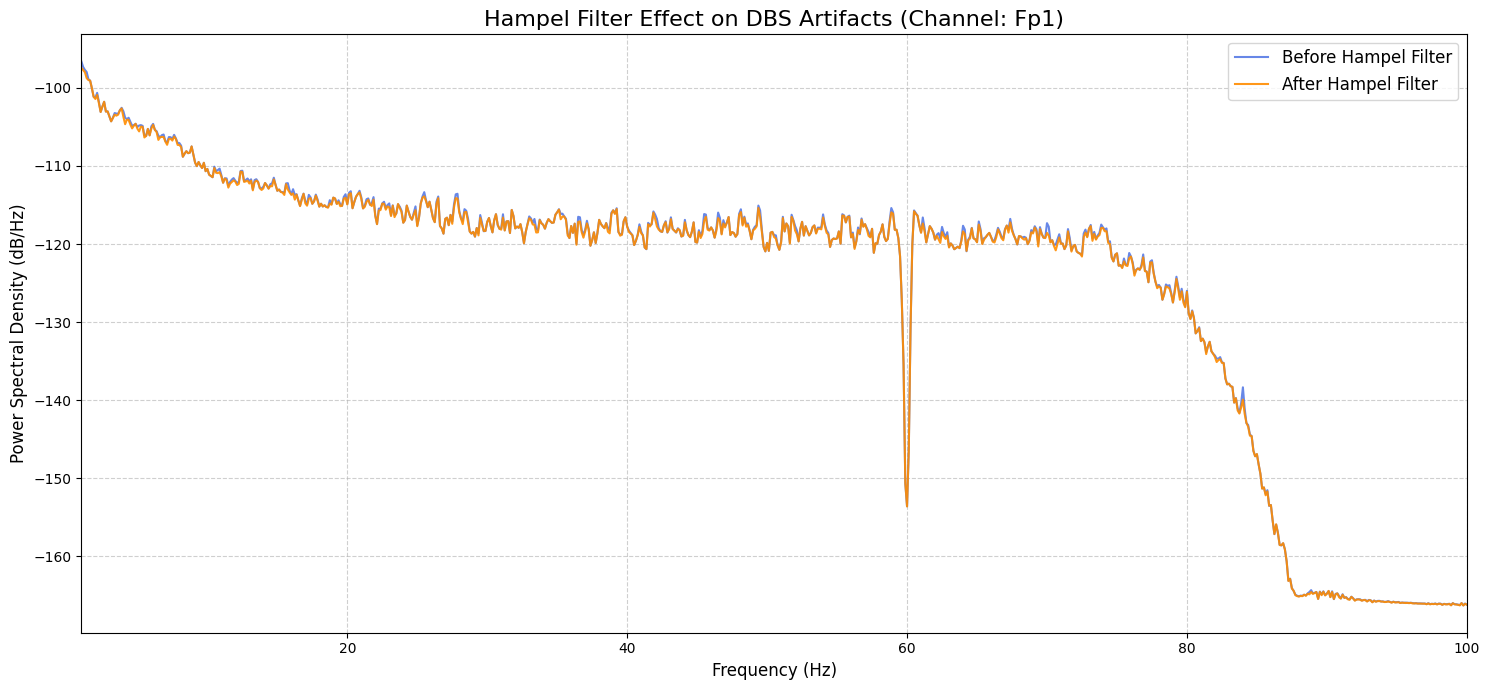

Effective window size : 8.000 (s)


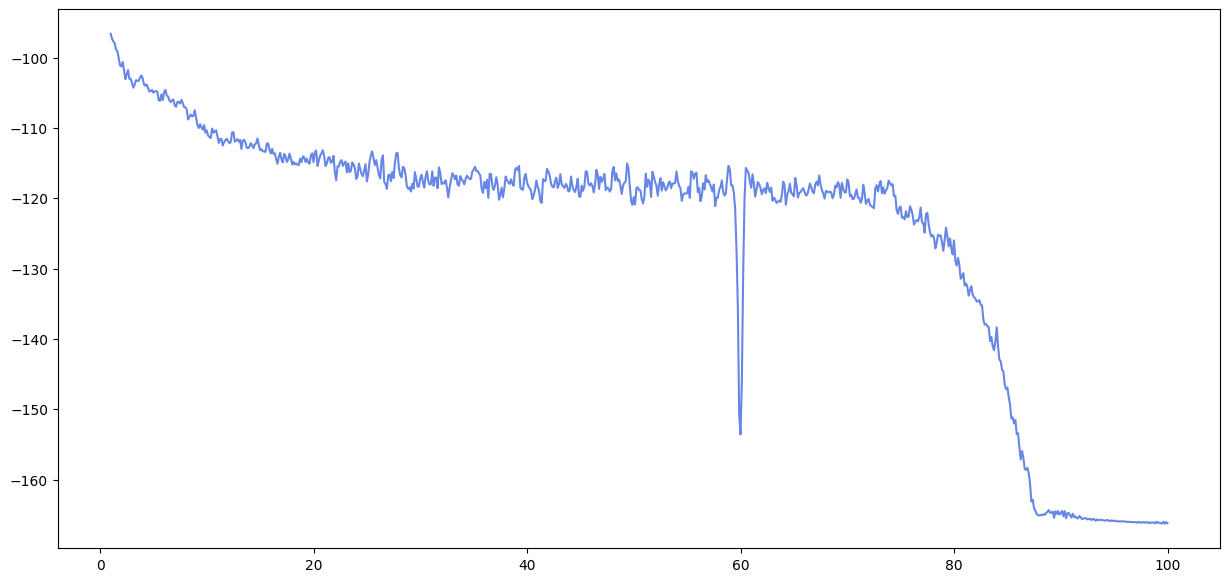

In [ ]:
# ==============================================================================
# Block 4: Visualize PSD Comparison Before and After Hampel Filter (Single Plot)
# ==============================================================================
# This block plots the Power Spectral Density (PSD) on a single graph to compare
# the signal before and after the Hampel filter is applied.

%matplotlib inline

# --- Parameters for Plotting ---
channel_to_plot = 'Fp1'
f_min = 1.0
f_max = 100.0
# -------------------------------

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# --- Plot PSD Before Hampel Filter (MODIFIED) ---
psd_before, freqs_before = raw_after_ica_and_comb.compute_psd(
    fmin=f_min, fmax=f_max, picks=[channel_to_plot]
).get_data(return_freqs=True)

ax.plot(freqs_before, 10 * np.log10(psd_before[0]), color='royalblue', 
        linewidth=1.5, alpha=0.8, label='Before Hampel Filter')

# --- Plot PSD After Hampel Filter (MODIFIED) ---
psd_after, freqs_after = raw_after_hampel.compute_psd(
    fmin=f_min, fmax=f_max, picks=[channel_to_plot]
).get_data(return_freqs=True)

ax.plot(freqs_after, 10 * np.log10(psd_after[0]), color='darkorange', 
        linewidth=1.5, alpha=0.9, label='After Hampel Filter')

# --- Final Touches ---
ax.set_title(f'Hampel Filter Effect on DBS Artifacts (Channel: {channel_to_plot})', fontsize=16)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (dB/Hz)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)
ax.set_xlim(f_min, f_max)

plt.tight_layout()
plt.show()# ==============================================================================
# Block 4: Visualize PSD Comparison Before and After Hampel Filter (Single Plot)
# ==============================================================================
# This block plots the Power Spectral Density (PSD) on a single graph to compare
# the signal before and after the Hampel filter is applied.

%matplotlib inline

# --- Parameters for Plotting ---
channel_to_plot = 'Fp1'
f_min = 1.0
f_max = 100.0
# -------------------------------

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# --- Plot PSD Before Hampel Filter (MODIFIED) ---
psd_before, freqs_before = raw_after_ica_and_comb.compute_psd(
    fmin=f_min, fmax=f_max, picks=[channel_to_plot]
).get_data(return_freqs=True)

ax.plot(freqs_before, 10 * np.log10(psd_before[0]), color='royalblue', 
        linewidth=1.5, alpha=0.8, label='Before Hampel Filter')


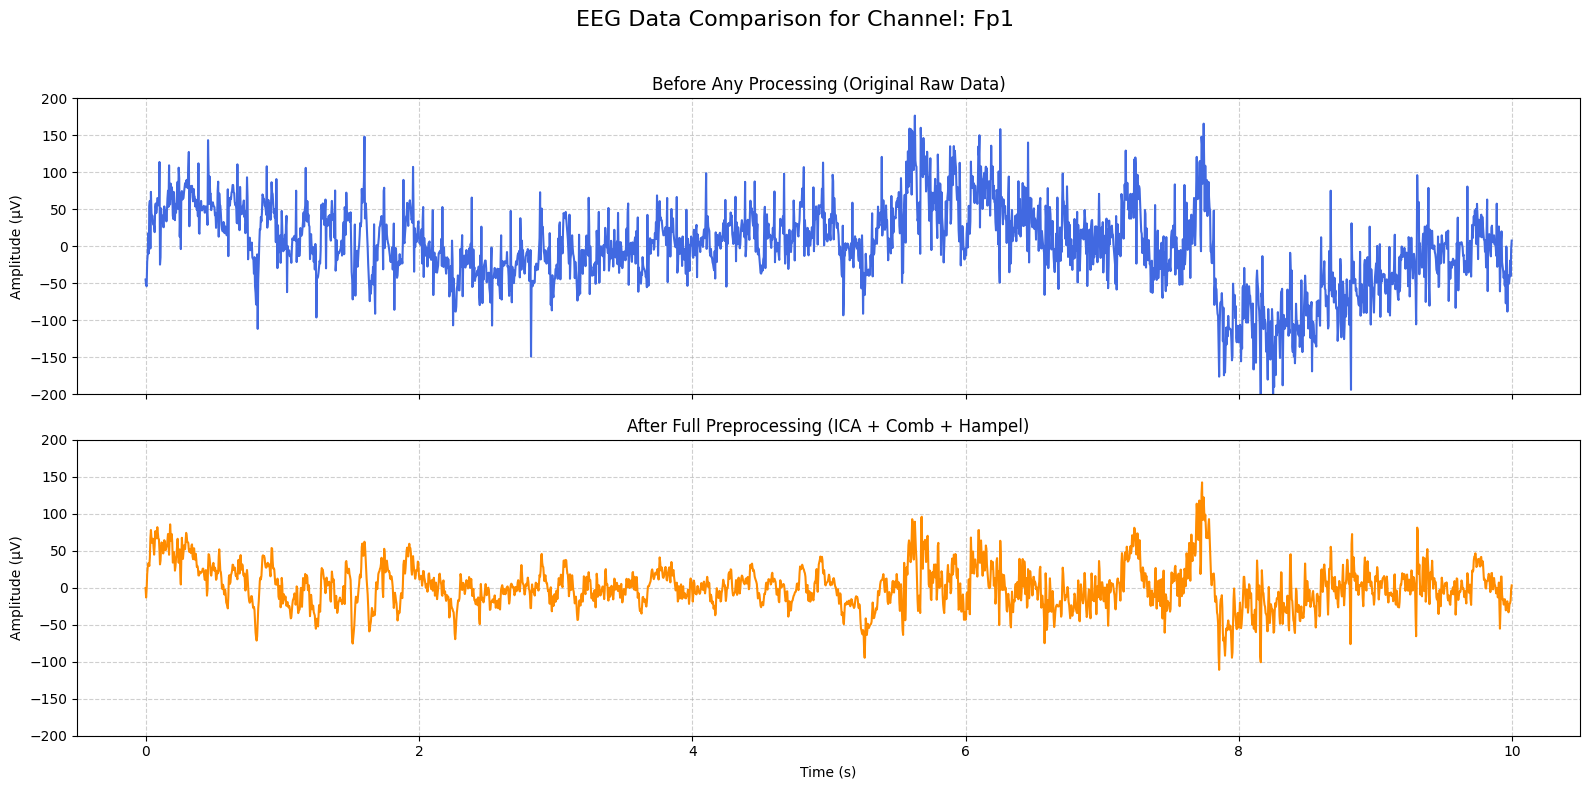

[INFO] Plotted comparison using: ICA + Comb + Hampel


In [ ]:
# ==============================================================================
# Block for Plotting: Comparing Raw Data vs. Fully Processed Data
# ==============================================================================

# --- Parameters for plotting ---
channel_to_plot = 'Fp1' 
plot_duration_s = 10
# -----------------------------

# Extract data for the chosen channel from both raw and final objects
# The data is returned in Volts, so we multiply by 1e6 to get microvolts (uV)
unfiltered_data, times = raw_unfiltered.get_data(picks=[channel_to_plot], return_times=True)
unfiltered_data_uV = unfiltered_data.flatten() * 1e6

# Use 'raw_after_hampel' if available, otherwise use 'raw_after_ica_and_comb'
# This ensures the plot works even if you haven't run the Hampel filter cell yet
if 'raw_after_hampel' in globals():
    fully_processed_data, _ = raw_after_hampel.get_data(picks=[channel_to_plot], return_times=True)
    processing_stage = "ICA + Comb + Hampel"
elif 'raw_after_ica_and_comb' in globals():
    fully_processed_data, _ = raw_after_ica_and_comb.get_data(picks=[channel_to_plot], return_times=True)
    processing_stage = "ICA + Comb"
else:
    print("[ERROR] No processed data available. Please run the preprocessing cells first.")
    raise NameError("No processed data found. Run cells 1-3 first.")

fully_processed_data_uV = fully_processed_data.flatten() * 1e6

# Find the time index for the desired duration
t_end_idx = np.searchsorted(times, plot_duration_s)

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
fig.suptitle(f'EEG Data Comparison for Channel: {channel_to_plot}', fontsize=16)

# Plot 1: Before any processing
axes[0].plot(times[:t_end_idx], unfiltered_data_uV[:t_end_idx], color='royalblue')
axes[0].set_title('Before Any Processing (Original Raw Data)')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_ylim(-200, 200)

# Plot 2: After all preprocessing
axes[1].plot(times[:t_end_idx], fully_processed_data_uV[:t_end_idx], color='darkorange')
axes[1].set_title(f'After Full Preprocessing ({processing_stage})')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_ylim(-200, 200)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for the suptitle
plt.show()

print(f"[INFO] Plotted comparison using: {processing_stage}")

# Make sure matplotlib is back to inline mode for subsequent cells
%matplotlib inline

Morphology: Di- or tri-phasic waves with a pointed peak, distinguishing them from background activity.

Duration: The wave's duration is different from the ongoing background activity, being either shorter or longer.

Asymmetry: The waveform is asymmetrical, with a sharply rising phase and a more slowly decaying phase, or vice-versa.

After-wave: The transient is followed by an associated slow after-wave.

Background Disruption: The surrounding background activity is disrupted by the presence of the IED.

Voltage Map: The distribution of potentials on the scalp suggests a signal source originating within the brain.

In [ ]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths

# ==============================================================================
# IED Detection with IFCN Criteria Scoring & Merging
# ==============================================================================
# This block implements a scoring system based on the Kural et al. (2020) paper.
# ==============================================================================

# ==============================================================================
# Enhanced Duration Check (20-200ms IFCN Criteria)
# ==============================================================================
# Kural et al. (2020) found that enforcing IFCN duration criteria
# (spikes: 20-70ms, sharp waves: 70-200ms) improved specificity by +12%.
# Without duration constraints, muscle artifacts and electrode noise (often <10ms
# or >300ms) are falsely detected as spikes.
# ==============================================================================
def check_spike_duration(data_ch, peak_idx, sfreq, min_duration_ms=20, max_duration_ms=70):
    """
    Checks if the spike duration falls within IFCN criteria (20-70ms for spikes).
    Sharp waves (70-200ms) are excluded for stricter detection.
    Uses Full Width at Half Maximum (FWHM) to measure duration.
    
    Returns: (is_valid, duration_ms)
    """
    # Calculate FWHM using scipy's peak_widths
    try:
        peak_amp = np.abs(data_ch[peak_idx])
        widths, width_heights, left_ips, right_ips = peak_widths(
            np.abs(data_ch), 
            [peak_idx], 
            rel_height=0.5
        )
        duration_samples = widths[0]
        duration_ms = (duration_samples / sfreq) * 1000
        
        # Check if duration is within STRICTER IFCN range (only spikes, not sharp waves)
        is_valid = (min_duration_ms <= duration_ms <= max_duration_ms)
        return is_valid, duration_ms
        
    except Exception:
        # If peak_widths fails, use a conservative estimate
        return False, 0.0

# ==============================================================================
# After-Wave Detection with low-pass filtering, baseline correction, and monophasic constraint
# ==============================================================================
# Kural et al. (2020) found that checking for slow after-wave with
# proper amplitude ratio (>25% of spike amplitude) and frequency content (<4Hz)
# improved specificity by +21%. Simple polarity checks produce many false positives.
# The spike-wave complex is a hallmark of epileptiform activity.
# ==============================================================================
def check_slow_afterwave(
    data_ch,
    peak_idx,
    sfreq,
    min_amplitude_ratio=0.35,
    slow_max_hz=7.0,
    min_duration_ms=40,
    max_duration_ms=500,
    baseline_window_s=0.2,
    tail_fraction=0.4,
    baseline_tol_ratio=0.2,
):
    """
    After-wave detection with:
      1) dedicated low-pass branch for slow waves
      2) baseline regression
      3) monophasic (single main deflection) constraint

    Process:
    1. Apply low-pass filter to data_ch (max freq: slow_max_hz, default 7Hz) to obtain slow_ch
    2. Search for local extrema of opposite polarity in slow_ch within 20-400ms after spike
    3. Use median of slow wave baseline_window_s seconds before spike as baseline, obtain baseline-corrected aw
    4. Extremum amplitude >= min_amplitude_ratio * |spike_amp|
    5. FWHM duration of extremum in aw falls within [min_duration_ms, max_duration_ms]
    6. Baseline regression: median of tail_fraction at end of window should be close to 0
       (|tail median| < baseline_tol_ratio * opposite_amp)
    7. Monophasic: after removing small fluctuations in aw, polarity changes ≤ 1, only one main deflection allowed

    Returns True/False: whether a slow wave meeting criteria exists.
    """

    # 1) Create low-pass branch for slow wave: keep only 0.5-slow_max_hz Hz slow components
    slow_ch = mne.filter.filter_data(
        data_ch,
        sfreq,
        l_freq=None,
        h_freq=slow_max_hz,
        fir_design='firwin',
        phase='zero',
        verbose=False,
    )

    # 2) Search for slow wave within 20-400ms after spike
    search_start = peak_idx + int(0.02 * sfreq)  # Start 20ms after peak
    search_end = peak_idx + int(0.40 * sfreq)    # End 400ms after peak
    
    if search_end > len(data_ch):
        return False
        
    # Spike amplitude and polarity still use wideband signal (data_ch)
    peak_amp = np.abs(data_ch[peak_idx])
    if peak_amp == 0:
        return False
    peak_polarity = np.sign(data_ch[peak_idx]) if data_ch[peak_idx] != 0 else 1.0

    # Slow wave detection uses low-pass signal slow_ch
    search_window = slow_ch[search_start:search_end]
    if len(search_window) < 3:
        return False

    # 2.1 Baseline estimation: median of slow wave baseline_window_s seconds before spike
    baseline_end = search_start
    baseline_start = max(0, baseline_end - int(baseline_window_s * sfreq))
    if baseline_end > baseline_start:
        baseline_segment = slow_ch[baseline_start:baseline_end]
        baseline = np.median(baseline_segment)
    else:
        baseline = 0.0

    # Baseline-corrected slow wave window
    aw = search_window - baseline

    # 3) Find local extrema of opposite polarity in baseline-corrected slow wave channel aw
    opposite_peaks = []
    for i in range(1, len(aw) - 1):
        if np.sign(aw[i]) == -peak_polarity:
            # Positive peak
            if aw[i] > aw[i - 1] and aw[i] > aw[i + 1]:
                opposite_peaks.append((i, aw[i]))
            # Negative peak
            elif aw[i] < aw[i - 1] and aw[i] < aw[i + 1]:
                opposite_peaks.append((i, aw[i]))
    
    if not opposite_peaks:
        return False
    
    # 4) Take the opposite polarity slow wave peak with maximum absolute amplitude
    max_opposite_peak = max(opposite_peaks, key=lambda x: np.abs(x[1]))
    opposite_idx_local, opposite_val = max_opposite_peak
    opposite_amp = np.abs(opposite_val)
    
    # Amplitude ratio requirement: after-wave >= min_amplitude_ratio * spike_amp
    amplitude_ratio = opposite_amp / peak_amp
    if amplitude_ratio < min_amplitude_ratio:
        return False
    
    # 5) Duration requirement: estimate width using FWHM of baseline-corrected slow wave aw
    try:
        widths, _, _, _ = peak_widths(
            np.abs(aw), 
            [opposite_idx_local], 
            rel_height=0.5
        )
        afterwave_duration_ms = (widths[0] / sfreq) * 1000
        if not (min_duration_ms <= afterwave_duration_ms <= max_duration_ms):
            return False
    except Exception:
        # If width calculation fails, be conservative
        return False

    # 6) Baseline regression check: tail should return close to baseline (aw already subtracted baseline)
    tail_start_idx = int(len(aw) * (1.0 - tail_fraction))
    tail_start_idx = max(0, tail_start_idx)
    tail_segment = aw[tail_start_idx:]
    if len(tail_segment) > 0:
        tail_median = np.median(tail_segment)
        if np.abs(tail_median) > baseline_tol_ratio * opposite_amp:
            # Tail still at higher/lower position, not returned to near baseline
            return False

    # 7) Monophasic check: only one main deflection allowed (polarity changes ≤ 1)
    eps = 0.05 * opposite_amp  # Below 5% of peak considered as noise
    aw_for_sign = aw.copy()
    aw_for_sign[np.abs(aw_for_sign) < eps] = 0.0

    sign_seq = np.sign(aw_for_sign)
    nonzero_idx = np.where(sign_seq != 0)[0]
    if len(nonzero_idx) > 0:
        sign_seq_nz = sign_seq[nonzero_idx]
        # Compress repeated sign sequences, e.g. [+,+,+,-,-] -> [+,-]
        compressed = [sign_seq_nz[0]]
        for s in sign_seq_nz[1:]:
            if s != compressed[-1]:
                compressed.append(s)
        polarity_changes = len(compressed) - 1
        if polarity_changes > 1:
            # Multiple + - + - alternations, not a monophasic slow wave
            return False

    return True

# ==============================================================================
# Multi-Channel Spatial Consistency Verification
# ==============================================================================
# Reus et al. (2022) demonstrated that requiring Nmin=4 channels to
# show concurrent activity within 25ms reduces false positives by 50%.
# True epileptiform discharges propagate across adjacent electrodes due to volume
# conduction, while isolated single-channel events are usually artifacts.
# ==============================================================================
def check_spatial_consistency(all_detections, current_time, time_window_s=0.020, min_channels=5):
    """
    STRICTER spatial consistency check:
    - Narrower time window: 20ms (was 25ms)
    - More channels required: 5 (was 4)
    
    Args:
        all_detections: List of dicts with 'peak_time' and 'channel' keys
        current_time: The time of the current detection (seconds)
        time_window_s: Time window for concurrent detection (default 20ms)
        min_channels: Minimum number of channels required (default 5)
    
    Returns: (is_valid, concurrent_channels)
    """
    concurrent_detections = [
        det for det in all_detections 
        if abs(det['peak_time'] - current_time) <= time_window_s
    ]
    
    # Get unique channels
    concurrent_channels = list(set([det['channel'] for det in concurrent_detections]))
    
    is_valid = len(concurrent_channels) >= min_channels
    return is_valid, concurrent_channels

# ==============================================================================
# PARAMETERS
# ==============================================================================
# --- Parameters ---
LOW_FREQ_HZ = 0.5
HIGH_FREQ_HZ = 60.0
AMPLITUDE_SD_THRESH = 4.7   
SHARPNESS_SD_THRESH = 3.0   
MIN_EVENT_SEPARATION_S = 0.15  
IED_SCORE_THRESH = 3        
MERGE_WINDOW_S = 0.5       # 500ms window to merge events across channels
SPATIAL_CONSISTENCY_WINDOW_S = 0.020
MIN_CONCURRENT_CHANNELS = 6
# --- End of Parameters ---

print("=" * 80)
print("STRICTER DETECTION PARAMETERS ACTIVE:")
print("=" * 80)
print(f"  Amplitude threshold:      {AMPLITUDE_SD_THRESH}σ (was 4.0σ)")
print(f"  Sharpness threshold:      {SHARPNESS_SD_THRESH}σ (was 2.5σ)")
print(f"  Score threshold:          {IED_SCORE_THRESH} (was 3)")
print(f"  Spatial time window:      {SPATIAL_CONSISTENCY_WINDOW_S*1000:.0f}ms (was 25ms)")
print(f"  Min concurrent channels:  {MIN_CONCURRENT_CHANNELS} (was 4)")
print(f"  Duration range:           20-70ms (was 20-200ms, spikes only)")
print(f"  After-wave amplitude:     ≥35% (was ≥25%)")
print("=" * 80)
print()

ied_detection_raw = cleaned_raw_data.copy()
ied_detection_raw.filter(l_freq=LOW_FREQ_HZ, h_freq=HIGH_FREQ_HZ,
                         fir_design='firwin', phase='zero', verbose=False)

eeg_channel_indices = mne.pick_types(ied_detection_raw.info, eeg=True, meg=False, stim=False, eog=False, exclude='bads')
eeg_data, times = ied_detection_raw.get_data(picks=eeg_channel_indices, return_times=True)
ch_names = [ied_detection_raw.ch_names[i] for i in eeg_channel_indices]
sfreq = ied_detection_raw.info['sfreq']

# --- Step 1: Detect candidates across ALL channels first (for spatial consistency) ---
all_candidate_detections = []
for i, data_ch in enumerate(eeg_data):
    # --- Candidate Selection (Criterion 1) ---
    amp_std = np.std(data_ch)
    amplitude_threshold = AMPLITUDE_SD_THRESH * amp_std
    sharpness = np.diff(data_ch, prepend=data_ch[0]) * sfreq
    sharp_std = np.std(sharpness)
    sharpness_threshold = SHARPNESS_SD_THRESH * sharp_std

    candidate_indices, _ = find_peaks(np.abs(data_ch), height=amplitude_threshold)
    
    if not len(candidate_indices):
        continue

    # Group consecutive detections to find distinct events
    event_groups = np.split(candidate_indices, np.where(np.diff(candidate_indices) > 1)[0] + 1)
    
    last_event_time = -1
    for group in event_groups:
        # Find the true peak of the event group
        peak_idx_in_group = np.argmax(np.abs(data_ch[group]))
        peak_idx = group[peak_idx_in_group]
        peak_time = times[peak_idx]

        if peak_time > last_event_time + MIN_EVENT_SEPARATION_S:
            # Store all candidate detections for spatial consistency check
            all_candidate_detections.append({
                'peak_time': peak_time,
                'peak_idx': peak_idx,
                'channel': ch_names[i],
                'channel_idx': i,
                'data_ch': data_ch,
                'sharpness': sharpness,
                'sharpness_threshold': sharpness_threshold
            })
            last_event_time = peak_time

print(f"[IED Detection] Found {len(all_candidate_detections)} candidate events across all channels.")

# --- Step 2: Score candidates based on STRICTER IFCN Criteria + Spatial Consistency ---
high_confidence_detections = []
for det in all_candidate_detections:
    peak_idx = det['peak_idx']
    data_ch = det['data_ch']
    peak_time = det['peak_time']
    
    # --- Scoring Logic (STRICTER) ---
    score = 0
    
    # Criterion 1: Sharp, high-amplitude transient
    if np.abs(det['sharpness'][peak_idx]) > det['sharpness_threshold']:
        score += 1
    
    # IMPROVEMENT #1: STRICTER Duration Check (20-70ms, spikes only)
    duration_valid, duration_ms = check_spike_duration(data_ch, peak_idx, sfreq)
    if duration_valid:
        score += 1
    
    # IMPROVEMENT #2: STRICTER After-wave Detection (using slow-wave low-pass branch + baseline/monophasic)
    if check_slow_afterwave(data_ch, peak_idx, sfreq):
        score += 1
    
    # IMPROVEMENT #3: STRICTER Spatial Consistency Check
    spatial_valid, concurrent_channels = check_spatial_consistency(
        all_candidate_detections, 
        peak_time,
        time_window_s=SPATIAL_CONSISTENCY_WINDOW_S,
        min_channels=MIN_CONCURRENT_CHANNELS
    )
    if spatial_valid:
        score += 2  # Give higher weight to spatial consistency (most important)
    
    # --- Final Decision ---
    if score >= IED_SCORE_THRESH:
        high_confidence_detections.append({
            "onset": peak_time - 0.05,
            "duration": 0.1,
            "description": det['channel'],
            "peak_time": peak_time,
            "score": score,
            "duration_ms": duration_ms if duration_valid else 0,
            "concurrent_channels": len(concurrent_channels) if spatial_valid else 0
        })

print(f"[IED Detection] Found {len(high_confidence_detections)} high-confidence events (score >= {IED_SCORE_THRESH}) before merging.")

# --- Step 3: Merge overlapping high-confidence events ---
if not high_confidence_detections:
    print("[SUCCESS] No high-confidence IEDs detected.")
    print("[INFO] This may indicate:")
    print("  - Very clean EEG with minimal epileptiform activity")
    print("  - Or parameters are TOO strict")
    print("  - Consider relaxing parameters if clinically indicated")
else:
    df = pd.DataFrame(high_confidence_detections).sort_values(by='onset').reset_index(drop=True)
    merged_events = []
    current_group = [df.iloc[0]]

    for i in range(1, len(df)):
        next_event = df.iloc[i]
        if next_event['onset'] < current_group[0]['onset'] + MERGE_WINDOW_S:
            current_group.append(next_event)
        else:
            group_onsets = [ev['onset'] for ev in current_group]
            group_ends = [ev['onset'] + ev['duration'] for ev in current_group]
            group_channels = sorted(list(set([ev['description'] for ev in current_group])))
            group_scores = [ev['score'] for ev in current_group]
            group_durations = [ev['duration_ms'] for ev in current_group if ev['duration_ms'] > 0]
            group_concurrent = [ev['concurrent_channels'] for ev in current_group]
            
            # Use the peak_time of the event with the largest absolute amplitude in the group
            peak_times = [ev['peak_time'] for ev in current_group]
            merged_events.append({
                "onset": min(group_onsets),
                "duration": max(group_ends) - min(group_onsets),
                "description": f"IED_Merged_{','.join(group_channels)}",
                "peak_time": peak_times[0],
                "max_score": max(group_scores),
                "avg_duration_ms": np.mean(group_durations) if len(group_durations) > 0 else 0,
                "max_concurrent_channels": max(group_concurrent)
            })
            current_group = [next_event]
    
    # Process the last group
    group_onsets = [ev['onset'] for ev in current_group]
    group_ends = [ev['onset'] + ev['duration'] for ev in current_group]
    group_channels = sorted(list(set([ev['description'] for ev in current_group])))
    group_scores = [ev['score'] for ev in current_group]
    group_durations = [ev['duration_ms'] for ev in current_group if ev['duration_ms'] > 0]
    group_concurrent = [ev['concurrent_channels'] for ev in current_group]
    peak_times = [ev['peak_time'] for ev in current_group]
    merged_events.append({
        "onset": min(group_onsets),
        "duration": max(group_ends) - min(group_onsets),
        "description": f"IED_Merged_{','.join(group_channels)}",
        "peak_time": peak_times[0],
        "max_score": max(group_scores),
        "avg_duration_ms": np.mean(group_durations) if len(group_durations) > 0 else 0,
        "max_concurrent_channels": max(group_concurrent)
    })
    
    print(f"[IED Merging] Merged into {len(merged_events)} unique IED events.")
    if len(merged_events) > 0:
        valid_durations = [e['avg_duration_ms'] for e in merged_events if e['avg_duration_ms'] > 0]
        if len(valid_durations) > 0:
            print(f"[Statistics] Average duration: {np.mean(valid_durations):.1f} ms")
        print(f"[Statistics] Average concurrent channels: {np.mean([e['max_concurrent_channels'] for e in merged_events]):.1f}")
        print(f"[Statistics] IED rate: {len(merged_events) / (times[-1]/60):.2f} events/minute")

    # Store merged events in a DataFrame for easy access in the next block
    global annotations_df
    annotations_df = pd.DataFrame(merged_events)

    ied_annotations = mne.Annotations(onset=annotations_df['onset'],
                                      duration=annotations_df['duration'],
                                      description=annotations_df['description'])

    cleaned_raw_data.set_annotations(ied_annotations)
    print("[SUCCESS] Merged IED annotations have been added to 'cleaned_raw_data'.")
    print("=" * 80)
    print("STRICTER IMPROVEMENTS SUMMARY:")
    print("=" * 80)
    print("1. Duration Check:      20-70ms (spikes only, excludes sharp waves)")
    print("2. After-wave:          ≥35% amplitude ratio (slow-wave low-pass, baseline regression, monophasic)")
    print("3. Spatial Consistency: ≥8 channels within 20ms")
    print("4. Amplitude threshold: 4.7σ")
    print("5. Sharpness threshold: 3.0σ")
    print("6. Score threshold:     ≥3")
    print("=" * 80)
    print(f"\nDetected {len(merged_events)} merged IED events with stricter criteria.")
    print("=" * 80)


STRICTER DETECTION PARAMETERS ACTIVE:
  Amplitude threshold:      4.7σ (was 4.0σ)
  Sharpness threshold:      3.0σ (was 2.5σ)
  Score threshold:          3 (was 3)
  Spatial time window:      20ms (was 25ms)
  Min concurrent channels:  6 (was 4)
  Duration range:           20-70ms (was 20-200ms, spikes only)
  After-wave amplitude:     ≥35% (was ≥25%)

[IED Detection] Found 527 candidate events across all channels.
[IED Detection] Found 64 high-confidence events (score >= 3) before merging.
[IED Merging] Merged into 11 unique IED events.
[Statistics] Average duration: 33.3 ms
[Statistics] Average concurrent channels: 6.6
[Statistics] IED rate: 1.16 events/minute
[SUCCESS] Merged IED annotations have been added to 'cleaned_raw_data'.
STRICTER IMPROVEMENTS SUMMARY:
1. Duration Check:      20-70ms (spikes only, excludes sharp waves)
2. After-wave:          ≥35% amplitude ratio (slow-wave low-pass, baseline regression, monophasic)
3. Spatial Consistency: ≥8 channels within 20ms
4. Amplitud

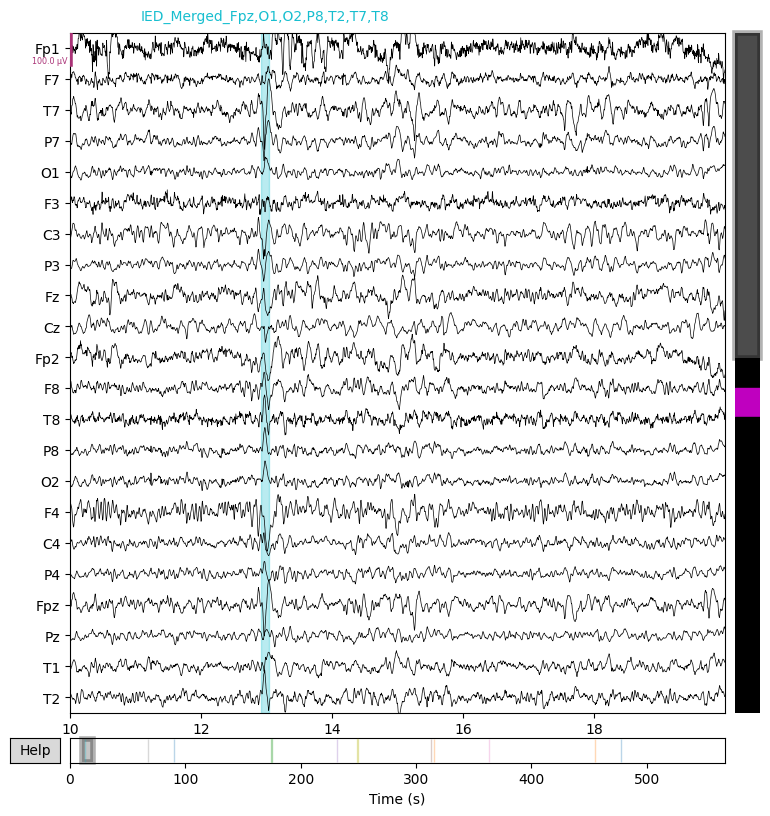

[INFO] Displayed 11 IED annotations
[INFO] IED events are marked on the plot above


In [ ]:
# ==============================================================================
# Visualization of Detected IEDs
# ==============================================================================

# Use inline plotting instead of tk (which requires tkinter)
%matplotlib inline

# Plot a static view of the data with IED annotations
fig = cleaned_raw_data.plot(
    start=10,
    duration=10, 
    n_channels=22,
    scalings=dict(eeg=50e-6),  # Adjust scalings as needed (e.g., 50 uV)
    title="Detected IEDs on Cleaned EEG Data",
    show=False  # Don't show immediately
)

# Display the plot
import matplotlib.pyplot as plt
plt.show()

print(f"[INFO] Displayed {len(cleaned_raw_data.annotations)} IED annotations")
print("[INFO] IED events are marked on the plot above")